**IMPORT**

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt

import keras.applications as kapp  
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 
try:
    import tensorflow as tf
except:
    import traceback
    traceback.print_exc()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
     
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
# plt.style.use("ggplot")

Using plaidml.keras.backend backend.


**DATA INGESTION AND EXPLORATION**

In [2]:
# df_portfolio = pd.read_csv("portfolio_template.csv")
# df_portfolio.info()

In [3]:
def stock_dataframe(name: str = "stock/ticker symbol"):
    _stock_info = yf.Ticker(name)
    df = _stock_info.history(period="max")
    df = df.drop(['Dividends','Stock Splits'], axis=1)
    df = df[df.index>'1990-01-01'][df.index<'2020-03-01']
    df = df[df['Volume']>0]
    # df['Year-Week'] = df.index.strftime('%d-%U-%Y')
    # df = df.set_index('Year-Week')
    return df

def plot_close_price(df):
    df.plot.line(y="Close",use_index=True,)

def get_all_sub_df(df,divs):
    no_of_plots = int(df.count()[0]/divs)
    fig, axs = plt.subplots(int(no_of_plots/2)+1, 2, figsize=(80, 80))
    fig.suptitle('Vertically stacked subplots')
    _count=1
    for i in range(no_of_plots):
        _df = df.iloc[i*divs:i*divs+divs]
        if _count==1:
            axs[i//2][0].plot(_df.index, _df['Close'])
            axs[i//2][0].set_xticklabels(_df.index,rotation=45, ha='right')
            _count+=1
        else:
            axs[i//2][1].plot(_df.index, _df['Close'])
            axs[i//2][1].set_xticklabels(_df.index,rotation=45, ha='right')
            _count = 1
    
    plt.savefig('foo.png', bbox_inches='tight')

def get_sub_df(df,divs,separate: bool = False):
    no_of_plots = int(df.count()[0]/divs)
    script_dir = os.path.curdir
    results_dir = os.path.join(script_dir, 'Outputs/')

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
        
    plt.figure(figsize = (40,20))
    if not separate:
        plt.plot(df.index, df['Close'])
        plt.xticks(rotation=90)
        file_name = "boo.png"
        plt.savefig(results_dir+file_name, bbox_inches='tight')
        return

    for i in range(no_of_plots):
        _df = df.iloc[i*divs:i*divs+divs]
        plt.plot(_df.index, _df['Close'])
        plt.xticks(rotation=45)
        file_name = f"par{i}.png"
        plt.savefig(results_dir+file_name, bbox_inches='tight')
        plt.clf()

def get_pred(df):
    train_size = int(len(df) * 0.8)
    train_set = df.iloc[:train_size,:]
    test_set = df.iloc[train_size:,:]

    scaler = MinMaxScaler(feature_range=(0,1))
    train_set_scaled = scaler.fit_transform(train_set)
    test_set_scaled = scaler.transform(test_set)

    def create_dataset(dataset, lookback=1):
        X, y = [], []
        for i in range(lookback, len(dataset)):
            X.append(dataset[i-lookback:i, 0])
            y.append(dataset[i, 0])
        return np.array(X), np.array(y)

    # Create the training and testing datasets
    lookback = 60
    X_train, y_train = create_dataset(train_set_scaled, lookback)
    X_test, y_test = create_dataset(test_set_scaled, lookback)

    # Reshape the datasets to be compatible with LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Define the LSTM model architecture
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=64)

    # Make predictions on the testing dataset
    y_pred = model.predict(X_test)

    # Calculate the root mean squared error (RMSE) of the predictions
    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print("Root Mean Squared Error: {:.2f}".format(rmse))

    # Scale the predictions back to the original range
    # y_pred = scaler.inverse_transform(y_pred)
    # y_test = scaler.inverse_transform(y_test)
    # print(y_pred)
    # print(y_test)   

    final_df = pd.DataFrame({"test":list(y_test),'pred':[float(i) for i in y_pred]})
    final_df["RMSE"] = np.sqrt(np.mean((final_df['pred'] - final_df['test'])**2))
    plt.plot(df.index[1438:],final_df['pred'],"r",df.index[1438:],final_df['test'])
    return(model)

In [4]:
df = stock_dataframe("^NSEI")
df = df.reset_index()
# plot_close_price(df)
# df = df['Close']
# type(df)
# df = pd.DataFrame(df)
# df = df.drop(['Open','High','Low','Volume'],axis=1)
# model = get_pred(df)


In [5]:
# get_sub_df(df,90)
# get_all_sub_df(df,90)
# get_sub_df(df,90,True)

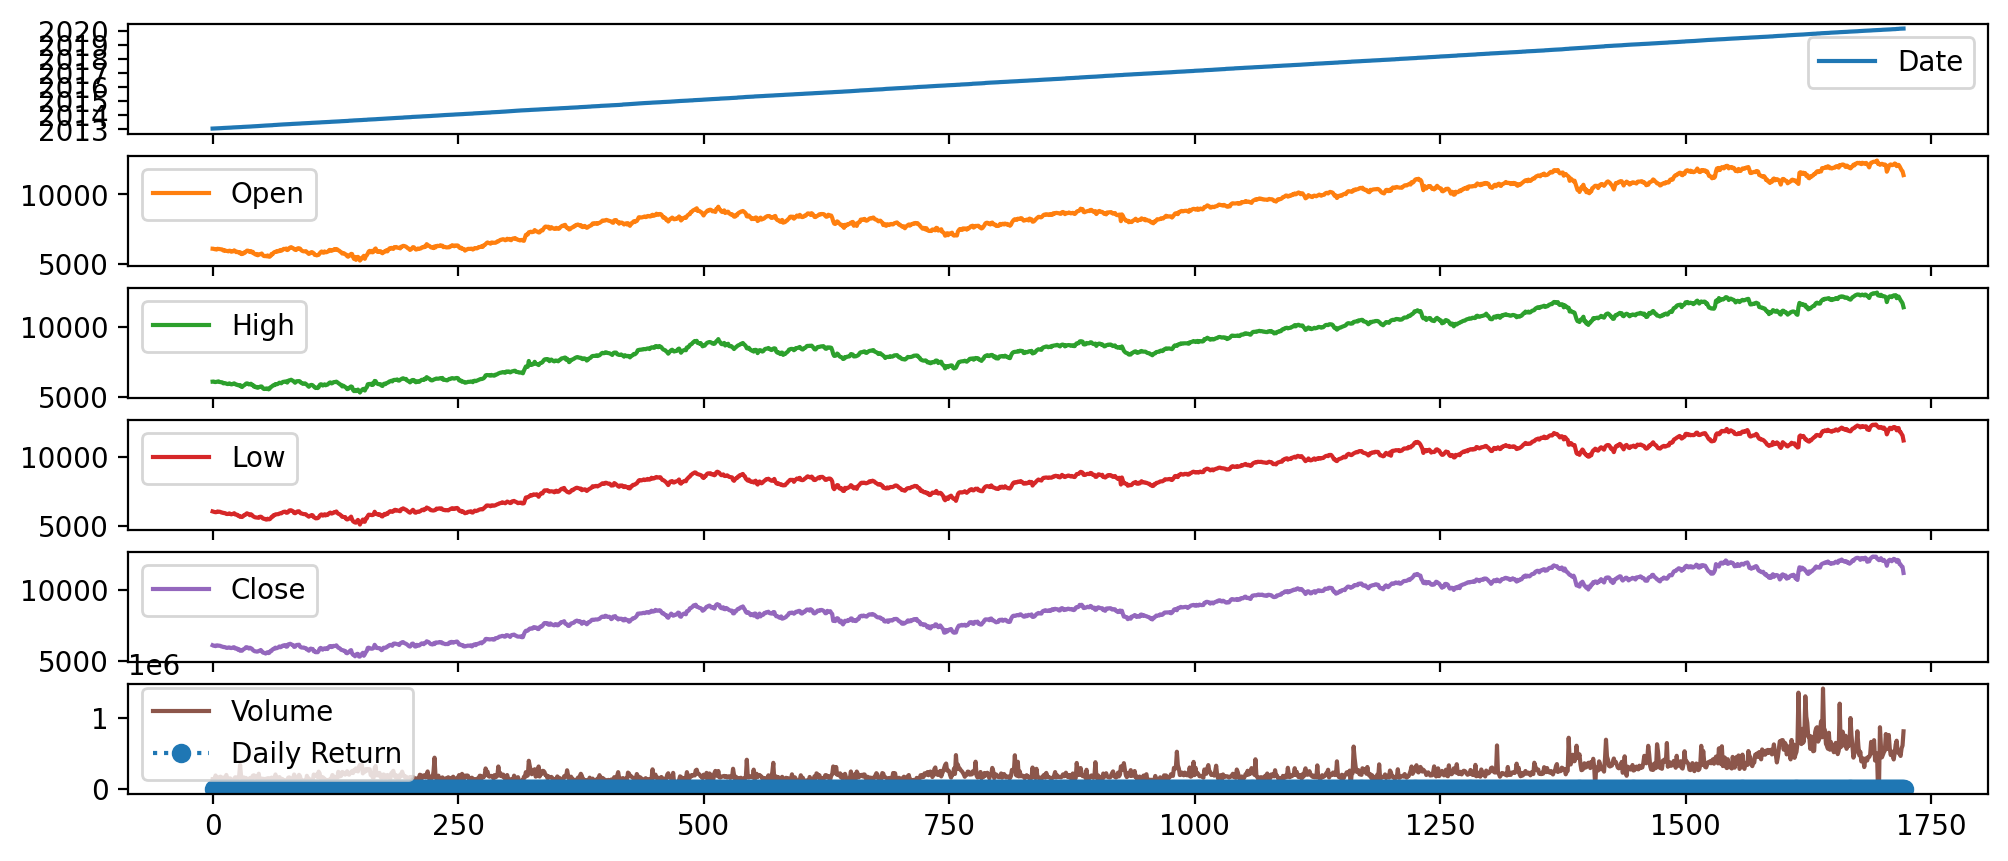

C:\Users\karth\AppData\Local\Temp\ipykernel_13044\408250759.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Daily Return"].dropna(),bins=100, color='green')


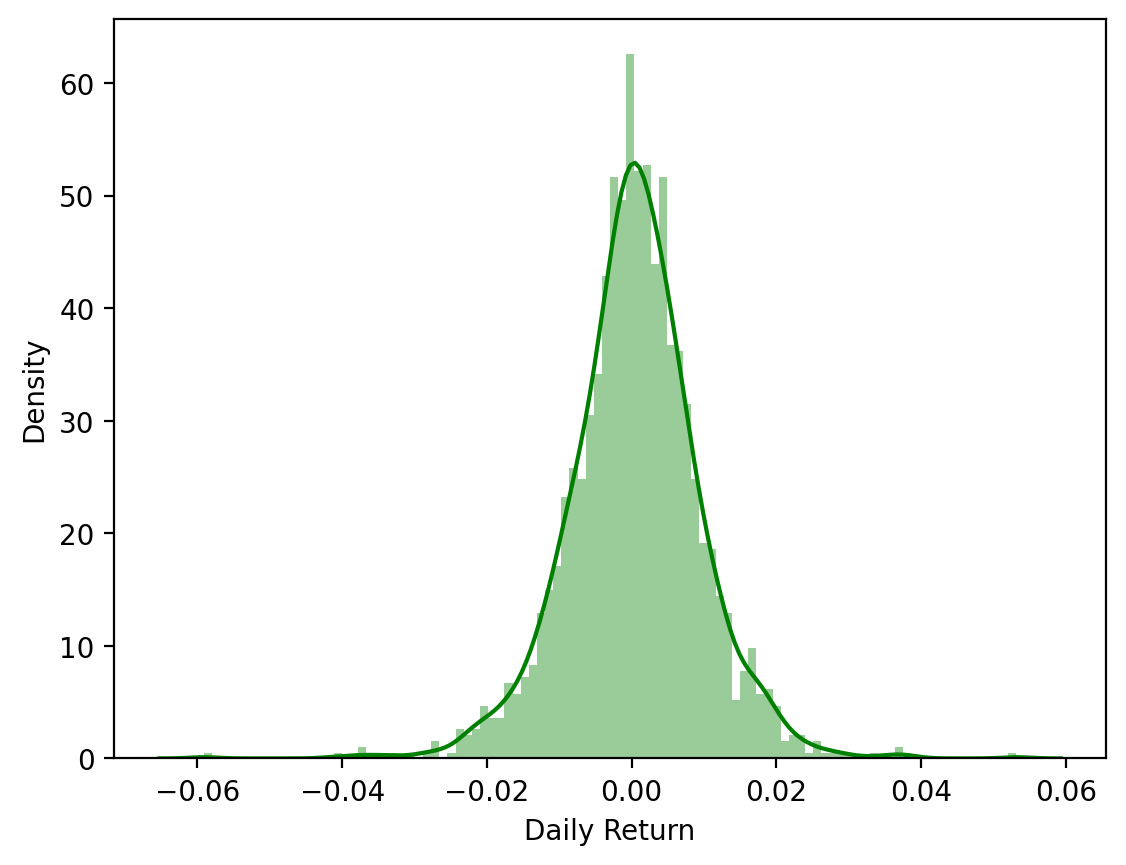

C:\Users\karth\AppData\Local\Temp\ipykernel_13044\408250759.py:23: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)


                          Date          Open          High           Low  \
0    2013-01-21 00:00:00+05:30   6085.750000   6094.350098   6065.100098   
1    2013-01-22 00:00:00+05:30   6080.149902   6101.299805   6040.500000   
2    2013-01-23 00:00:00+05:30   6052.850098   6069.799805   6021.149902   
3    2013-01-24 00:00:00+05:30   6046.200195   6065.299805   6007.850098   
4    2013-01-25 00:00:00+05:30   6024.500000   6080.549805   6014.450195   
...                        ...           ...           ...           ...   
1718 2020-02-24 00:00:00+05:30  12012.549805  12012.549805  11813.400391   
1719 2020-02-25 00:00:00+05:30  11877.500000  11883.049805  11779.900391   
1720 2020-02-26 00:00:00+05:30  11738.549805  11783.250000  11639.599609   
1721 2020-02-27 00:00:00+05:30  11661.250000  11663.849609  11536.700195   
1722 2020-02-28 00:00:00+05:30  11382.000000  11384.799805  11175.049805   

             Close  Volume         MA_10         MA_50        MA_100  \
0      6082.299

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
MA_10           0
MA_50           0
MA_100          0
Daily Return    0
dtype: int64

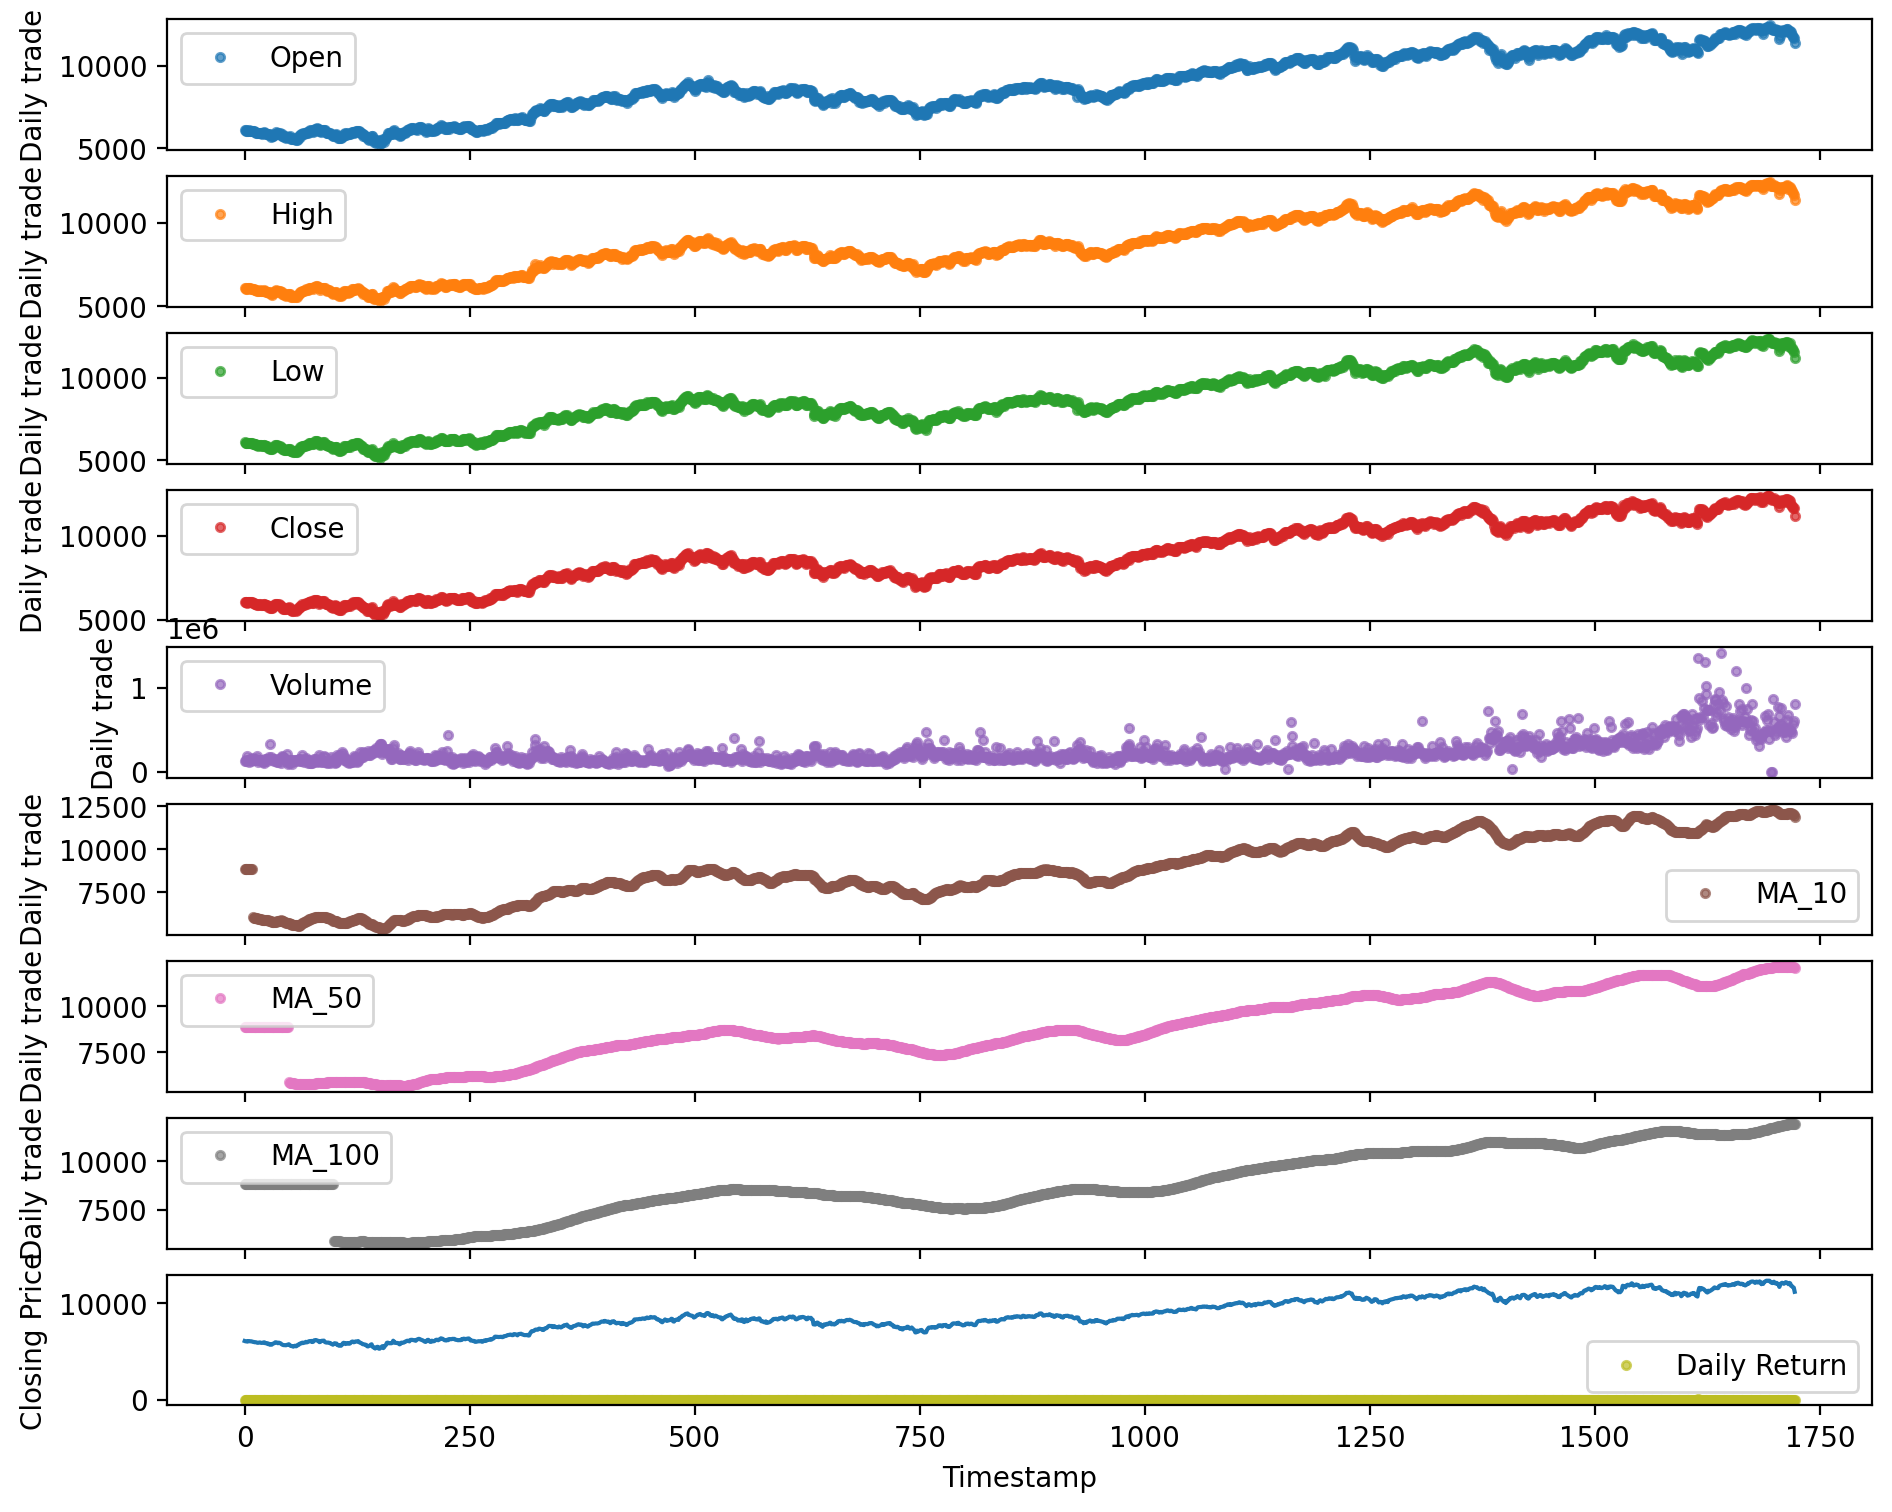

In [6]:
df = stock_dataframe("^NSEI")
df = df.reset_index()
df.plot(legend=True, subplots=True, figsize=(12,6))
mov_avg =[10,50,100]

for i in mov_avg:
    col_name = f"MA_{i}"
    df[col_name] = pd.DataFrame.rolling(df['Close'],i).mean()

df["Daily Return"] = df['Close'].pct_change()
df['Daily Return'].plot(figsize=(12,5),legend=True, linestyle=":", marker='o')
plt.show()
sns.distplot(df["Daily Return"].dropna(),bins=100, color='green')
plt.show()

date = pd.DataFrame(df['Date'])
closing_df1 = pd.DataFrame(df['Close'])
close1 = closing_df1.rename(columns={'Close':'data_close'})
close2 = pd.concat([df,close1],axis=1)
close2.head()

df.reset_index(drop=True, inplace=True)
df.fillna(df.mean(), inplace=True)
df.head()
df.nunique()
df.sort_index(axis=1,ascending=True)

cols_plot = ['Open','High','Low','Close','Volume','MA_10','MA_50','MA_100', 'Daily Return']
axes = df[cols_plot].plot(marker='.',alpha=0.7, linestyle='None', figsize=(11,9),subplots=True)
for i in axes:
    i.set_ylabel('Daily trade')

plt.plot(df['Close'],label='Close Price')
plt.xlabel('Timestamp')
plt.ylabel('Closing Price')
plt.savefig('./Outputs/data_viz.png', bbox_inches='tight')
print(df)
df.isnull().sum()

In [7]:
df.reset_index(drop=True, inplace=True)     
df.fillna(df.mean(), inplace=True)
df.head()

C:\Users\karth\AppData\Local\Temp\ipykernel_13044\1543525824.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)


,Date,Open,High,Low,Close,Volume,MA_10,MA_50,MA_100,Daily Return
0,2013-01-21 00:00:00+05:30,6085.750000,6094.350098,6065.100098,6082.299805,130900,8857.106429,8853.541388,8850.855269,0.000396
1,2013-01-22 00:00:00+05:30,6080.149902,6101.299805,6040.500000,6048.500000,129000,8857.106429,8853.541388,8850.855269,-0.005557
2,2013-01-23 00:00:00+05:30,6052.850098,6069.799805,6021.149902,6054.299805,137000,8857.106429,8853.541388,8850.855269,0.000959
3,2013-01-24 00:00:00+05:30,6046.200195,6065.299805,6007.850098,6019.350098,185200,8857.106429,8853.541388,8850.855269,-0.005773
4,2013-01-25 00:00:00+05:30,6024.500000,6080.549805,6014.450195,6074.649902,147600,8857.106429,8853.541388,8850.855269,0.009187


In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import yfinance as yf
_stock_info = yf.Ticker("^NSEI")
df = _stock_info.history(period="max")
df = df.drop(["Dividends", "Stock Splits"], axis=1)
df = df[df.index > "1990-01-01"][df.index < "2020-03-01"]
df = df[df["Volume"] > 0]

fig = go.Figure(data=go.Scatter(x=df.index, y=df["Close"]))

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(
    go.Scatter(x=df.index, y=df["Close"], name="Price"), secondary_y=False
)
fig2.add_trace(go.Bar(x=df.index, y=df["Volume"], name="Volume"), secondary_y=True)
fig2.update_yaxes(range=[0, 700000000], secondary_y=True)
fig2.update_yaxes(visible=False, secondary_y=True)

fig3 = make_subplots(specs=[[{"secondary_y": True}]])
fig3.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["Open"],
        close=df["Close"],
        high=df["High"],
        low=df["Low"],
    ),
    secondary_y=False,
)
fig3.add_trace(
    go.Scatter(x=df.index, y=df["Close"].rolling(20).mean(), name="20D-MA"),
    secondary_y=False,
)
fig3.add_trace(
    go.Scatter(x=df.index, y=df["Close"].rolling(100).mean(), name="100D-MA"),
    secondary_y=False,
)
fig3.add_trace(go.Bar(x=df.index, y=df["Volume"], name="Volume"), secondary_y=True)
fig3.update_yaxes(range=[0, 700000000], secondary_y=True)
fig3.update_yaxes(visible=False, secondary_y=True)
# fig2.show()
context = {
    "basic": fig.to_html(),
    "scatter": fig2.to_html(),
    "candle": fig3.to_html(),
}

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed